In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import joblib
from sklearn.ensemble import VotingClassifier
import lightgbm as lgb

print('Imports loaded')

Imports loaded


In [22]:
# Load the dataset
print('Loading dataframe...')
df = pd.read_csv('data/TOI_2025.10.04_05.29.58.csv', comment='#', on_bad_lines='skip')
df = df.drop(columns=['toi', 'tid', 'toi_created', 'rowupdate'])
print('Dataframe loaded successfully!\n')

print('Dataframe shape:', df.shape, '\n')

Loading dataframe...
Dataframe loaded successfully!

Dataframe shape: (7703, 19) 



In [23]:
# --- Data Cleaning ---
# Drop rows with missing values
df.dropna(inplace=True)
print('Dataframe shape after dropping missing values:', df.shape, '\n')


Dataframe shape after dropping missing values: (6589, 19) 



In [25]:
# --- Feature Selection ---
# Select numerical features
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Remove transit time column (if present) as it's a timestamp
if 'pl_tranmid' in numeric_cols:
    numeric_cols.remove('pl_tranmid')



In [26]:
# Prepare X and y
X = df[numeric_cols].copy()
y = df['tfopwg_disp'].copy()

print('Features used (numerical):', numeric_cols)
print('Missing values per feature:')
display(X.isnull().sum())

Features used (numerical): ['ra', 'dec', 'st_pmra', 'st_pmdec', 'pl_orbper', 'pl_trandurh', 'pl_trandep', 'pl_rade', 'pl_insol', 'pl_eqt', 'st_tmag', 'st_dist', 'st_teff', 'st_logg', 'st_rad']
Missing values per feature:


ra             0
dec            0
st_pmra        0
st_pmdec       0
pl_orbper      0
pl_trandurh    0
pl_trandep     0
pl_rade        0
pl_insol       0
pl_eqt         0
st_tmag        0
st_dist        0
st_teff        0
st_logg        0
st_rad         0
dtype: int64

In [ ]:
# --- One-vs-Rest SVM Classifiers ---
# Create and train a binary SVM classifier for each exoplanet category
classifiers = {}
for category in y.unique():
    print(f'Training a binary classifier for category: {category}')
    
    # Create a binary target for the current category
    y_binary = (y == category).astype(int)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42, stratify=y_binary)
    
    # Create a pipeline for each classifier
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('lgbm', lgb.LGBMClassifier(random_state=42)),
    ])
    
    # Define the parameter grid
    param_grid = {
        'lgbm__n_estimators': [100, 200, 500],
        'lgbm__learning_rate': [0.01, 0.05, 0.1],
        'lgbm__num_leaves': [31, 50, 70]
    }
    
    # Use GridSearchCV to find the best parameters
    grid = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, scoring='f1')
    grid.fit(X_train, y_train)
    
    print(f'Best parameters for {category}: {grid.best_params_}')
    print(f'Best CV score for {category}: {grid.best_score_}\n')
    
    # Store the best estimator
    classifiers[category] = grid.best_estimator_


Training a binary classifier for category: FP


Best parameters for FP: {'svc__C': 100, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
Best CV score for FP: 0.453173590249268

Training a binary classifier for category: PC
Best parameters for PC: {'svc__C': 100, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
Best CV score for PC: 0.7623222056099168

Training a binary classifier for category: KP
Best parameters for KP: {'svc__C': 100, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}
Best CV score for KP: 0.4208724594623056

Training a binary classifier for category: APC
Best parameters for APC: {'svc__C': 1, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}
Best CV score for APC: 0.27811296635878974

Training a binary classifier for category: FA
Best parameters for FA: {'svc__C': 1, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
Best CV score for FA: 0.04919433477430892

Training a binary classifier for category: CP
Best parameters for CP: {'svc__C': 100, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
Best CV score for CP: 0.4027367071362744



In [29]:
# --- Meta-Classifier (Voting Classifier) ---
# Combine the individual classifiers using a VotingClassifier
# The voting='soft' option uses the predicted probabilities to make the final decision
voting_clf = VotingClassifier(
    estimators=[(name, clf) for name, clf in classifiers.items()],
    voting='soft'
)

# We need to train the voting classifier on the original multi-class data
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
voting_clf.fit(X_train_multi, y_train_multi)

,estimators,"[('FP', ...), ('PC', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False


--- Classification Report for the Meta-Classifier ---
              precision    recall  f1-score   support

         APC       0.20      0.03      0.05        71
          CP       0.52      0.17      0.25       133
          FA       0.00      0.00      0.00        13
          FP       0.59      0.36      0.44       188
          KP       0.69      0.28      0.39       112
          PC       0.69      0.95      0.80       801

    accuracy                           0.67      1318
   macro avg       0.45      0.30      0.32      1318
weighted avg       0.62      0.67      0.61      1318



/home/tiyo/.conda/envs/exoplanet_classifier/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tiyo/.conda/envs/exoplanet_classifier/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tiyo/.conda/envs/exoplanet_classifier/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

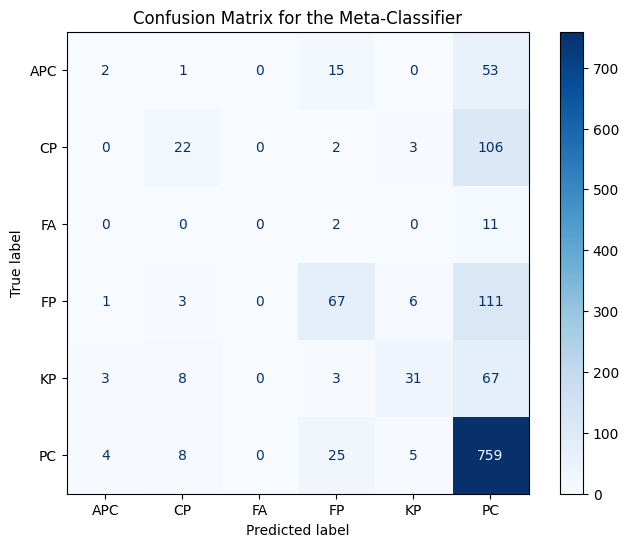

In [30]:
# --- Evaluation ---
# Evaluate the meta-classifier on the test set
y_pred_multi = voting_clf.predict(X_test_multi)

print("--- Classification Report for the Meta-Classifier ---")
print(classification_report(y_test_multi, y_pred_multi))

# Display the confusion matrix
cm = confusion_matrix(y_test_multi, y_pred_multi, labels=voting_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=voting_clf.classes_)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues')
plt.title('Confusion Matrix for the Meta-Classifier')
plt.show()


In [ ]:
# --- Save the Model ---
# Save the trained meta-classifier model
joblib.dump(voting_clf, 'voting_classifier_pipeline.joblib')
print('Meta-classifier model saved to voting_classifier_pipeline.joblib')